### This notebook includes the entire pipeline for the analysis after the necessary preprocessing that creates a (2040, 2639) feature matrix. At a high level, this notebook tunes a given classifier for predicting whether a speech recording is indicative of a speech disorder (0: Benign, 1: Anomalous). Then, the tuned classifier is used to predict instances within the test (hold out) set. ROC curves, Precision, Recall, and F-1 scores are also calculated outside of accuracy. Lastly, we interpret the constructed model through permutation importance, shapley importance, and partial dependency plots.

### Note: The results of the RCEFV with a simple random forests classifier are not shown here (a simple subset is created based on the results in the second code cell), although the process was a straightforward recursive feature elimination using a random forests model with default hyperparameters and step size of 1. Additionally, feature pruning based on correlation is conducted only to better improve interpretability (e.g., permutation feature importance is heavily influenced by highly correlated features). This additional reduction of features based on collinearity allows for better interpretability of the model at the cost of a slight predictive capability decrease.

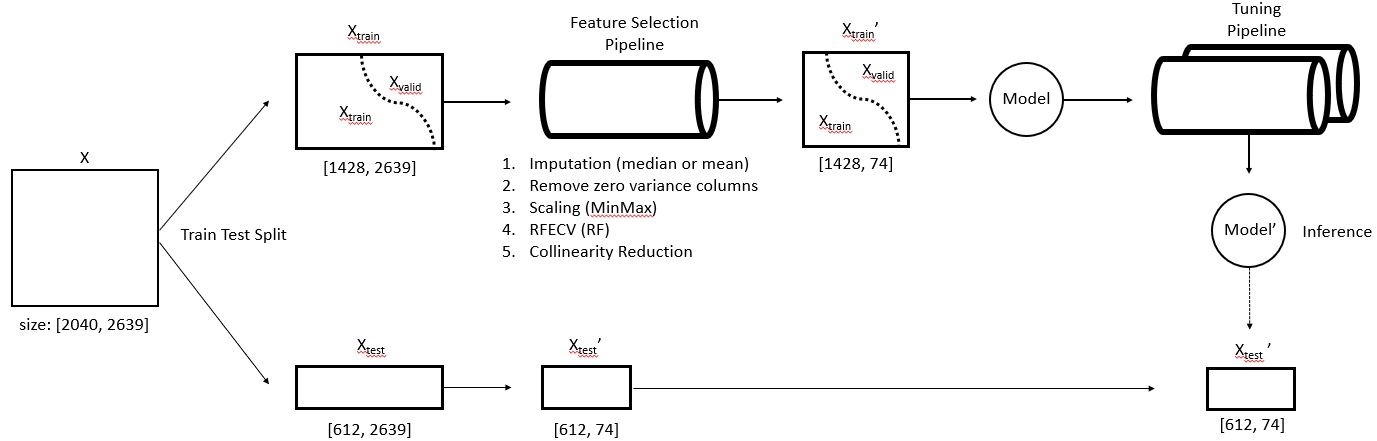

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from pylab import rcParams
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score
import pickle

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10

#### Read in data, and then subset based on RFECV results using a default RandomForestClassifier(). Import data and drop a few features.

In [2]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['y','age','sex','recording_num'], axis = 1)
num_feats_prior = X.shape[1]

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]
num_feats_after = X.shape[1]
print('Total number of features dropped was... ', num_feats_prior - num_feats_after, '\nRemaining features... ', num_feats_after)

Total number of features dropped was...  2535 
Remaining features...  104


#### Assess correlation between features, and drop individual features if they correlate highly (r > .8 chosen here) with any other features.

In [3]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)] 
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

Total number of features dropped was... 29 
Remaining features...  75


In [4]:
X = X.drop('high_indexphrase_features', axis = 1)

In [5]:
X.columns = ['Stdev Period l-a', 'Stdev MFCC-7 l-a', 'Mean Slope Melspec l-a', 'Mean Harmonicity l-a', 'Jitter (loc) h-a',
'Mean Slope Melspec h-a', 'Jitter (rap) lhl-a', 'Mean MFCC-2 lhl-a', 'Mean MFCC-7 lhl-a', 
'Stdev MFCC-2 lhl-a', 'Stdev Onset Envelope lhl-a', 'Stdev Pitches lhl-a', 'Mean Frequency n-a',
'Mean MFCC-8 n-a', 'LPC-1 n-a', 'Mean Slope Melspec n-a', 'Spec Power 1000Hz .25s n-a',
'Jitter (loc) l-i', 'Shimmer (apq11) l-i', 'Mean Magnitudes l-i', 'Mean Chromagram-4 l-i', 'Stdev Chromagram-4 l-i',
'Mean Slope (Hz) l-i', 'Mean MFCC-6 h-i', 'Mean Magnitudes h-i', 'Mean Slope (Hz) h-i', 'Mean MFCC-9 lhl-i',
'Mean Magnitudes lhl-i', 'Mean Harmony lhl-i', 'Mean Chromagram-0 n-i', 'Mean Slope Melspec n-i', 'Stdev Period l-u',
'Mean MFCC-4 l-u', 'Mean Slope (Hz) l-u', 'Mean Slope Melspec h-u', 'Mean MFCC-4 lhl-u', 'Mean Onset Envelope lhl-u',
'Stdev MFCC Delta-5 lhl-u', 'Stdev MFCC Delta-10 lhl-u', 'Stdev Period n-u', 'Mean Slope (Hz) n-u', 'HNR Phrases',
'Count of Periods Phrases', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean MFCC Delta-4 Phrases', 
'Mean MFCC Delta-11 Phrases', 'Stdev MFCC-2 Phrases', 'Stdev Onset Envelope Phrases', 'Max RMS Phrases',
'Stdev MFCC Delta-3 Phrases', 'Stdev MFCC Delta-7 Phrases', 'Spec Power 1000Hz .25s Phrases',
'Spec Power 1000Hz .5s Phrases','Spec Power 1000Hz .75s Phrases', 'CPPS Phrases', 'LSF-0 l-a', 
'Spectral Flux Stdev lhl-a', 'Spectral Spread Mean lhl-a', 'Spectral Spread Mean n-i',
'Shannon Entropy Sliding Window First Deriv Stdev n-i', 'f2 l-i', 'Spectral Skewness Mean h-i', 'Crest Factor Mean n-u',
'Pitch Period Entropy l-u', 'Spectral Flux First Deriv Mean Phrases', 'Spectral Entropy First Deriv Stdev Phrases',
'Spectral Spread Mean Phrases', 'Spectral Skewness First Deriv Stdev Phrases', 'Spectral Flatness Stdev Phrases', 
'Spectral Rolloff Stdev Phrases', 'Pitch Period Entropy Phrases', 'LPC-4 Phrases', 'Kurtosis Sliding Window First Deriv Mean Phrases']

### Import pickled versions of each model and test individual performance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

In [12]:
KNN_Pickled = 'KNN_1_25_.pkl'; SVM_Pickled = 'SVM_1_25_.pkl'
RF_Pickled = 'RF_1_25_.pkl'; GBC_Pickled = 'GBC_1_25_.pkl'

with open(KNN_Pickled, 'rb') as file:  
    tuned_knn = pickle.load(file)

with open(SVM_Pickled, 'rb') as file:  
    tuned_svm = pickle.load(file)
    
with open(RF_Pickled, 'rb') as file:  
    tuned_rf = pickle.load(file)

with open(GBC_Pickled, 'rb') as file:  
    tuned_gbc = pickle.load(file)    

print(classification_report(y_test, tuned_knn.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_knn.predict(X_test)))

print(classification_report(y_test, tuned_svm.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_svm.predict(X_test)))

print(classification_report(y_test, tuned_rf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_rf.predict(X_test)))

print(classification_report(y_test, tuned_gbc.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_gbc.predict(X_test)))

              precision    recall  f1-score   support

      benign     0.7290    0.7573    0.7429       206
   anomalous     0.8744    0.8571    0.8657       406

    accuracy                         0.8235       612
   macro avg     0.8017    0.8072    0.8043       612
weighted avg     0.8254    0.8235    0.8243       612

0.8235294117647058
              precision    recall  f1-score   support

      benign     0.7563    0.7233    0.7395       206
   anomalous     0.8627    0.8818    0.8721       406

    accuracy                         0.8284       612
   macro avg     0.8095    0.8025    0.8058       612
weighted avg     0.8269    0.8284    0.8275       612

0.8284313725490197
              precision    recall  f1-score   support

      benign     0.7627    0.6553    0.7050       206
   anomalous     0.8368    0.8966    0.8656       406

    accuracy                         0.8154       612
   macro avg     0.7997    0.7759    0.7853       612
weighted avg     0.8118    0.8154   

### Construct, fit, and evaluate performance of the stacking classifier.

In [17]:
from sklearn.ensemble import StackingClassifier
    
estimators = [
    ('knn', tuned_knn),
    ('svm', tuned_svm),
    ('rf', tuned_rf),
    ('gbc', tuned_gbc),
]

ensemble_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression()) 

ensemble_clf.fit(X_train, y_train)
print(classification_report(y_test, ensemble_clf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))

              precision    recall  f1-score   support

      benign     0.7817    0.7476    0.7643       206
   anomalous     0.8747    0.8941    0.8843       406

    accuracy                         0.8448       612
   macro avg     0.8282    0.8208    0.8243       612
weighted avg     0.8434    0.8448    0.8439       612



#### Create a receiver operating characteristic (ROC) curve and derive area under the curve (AUC).

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

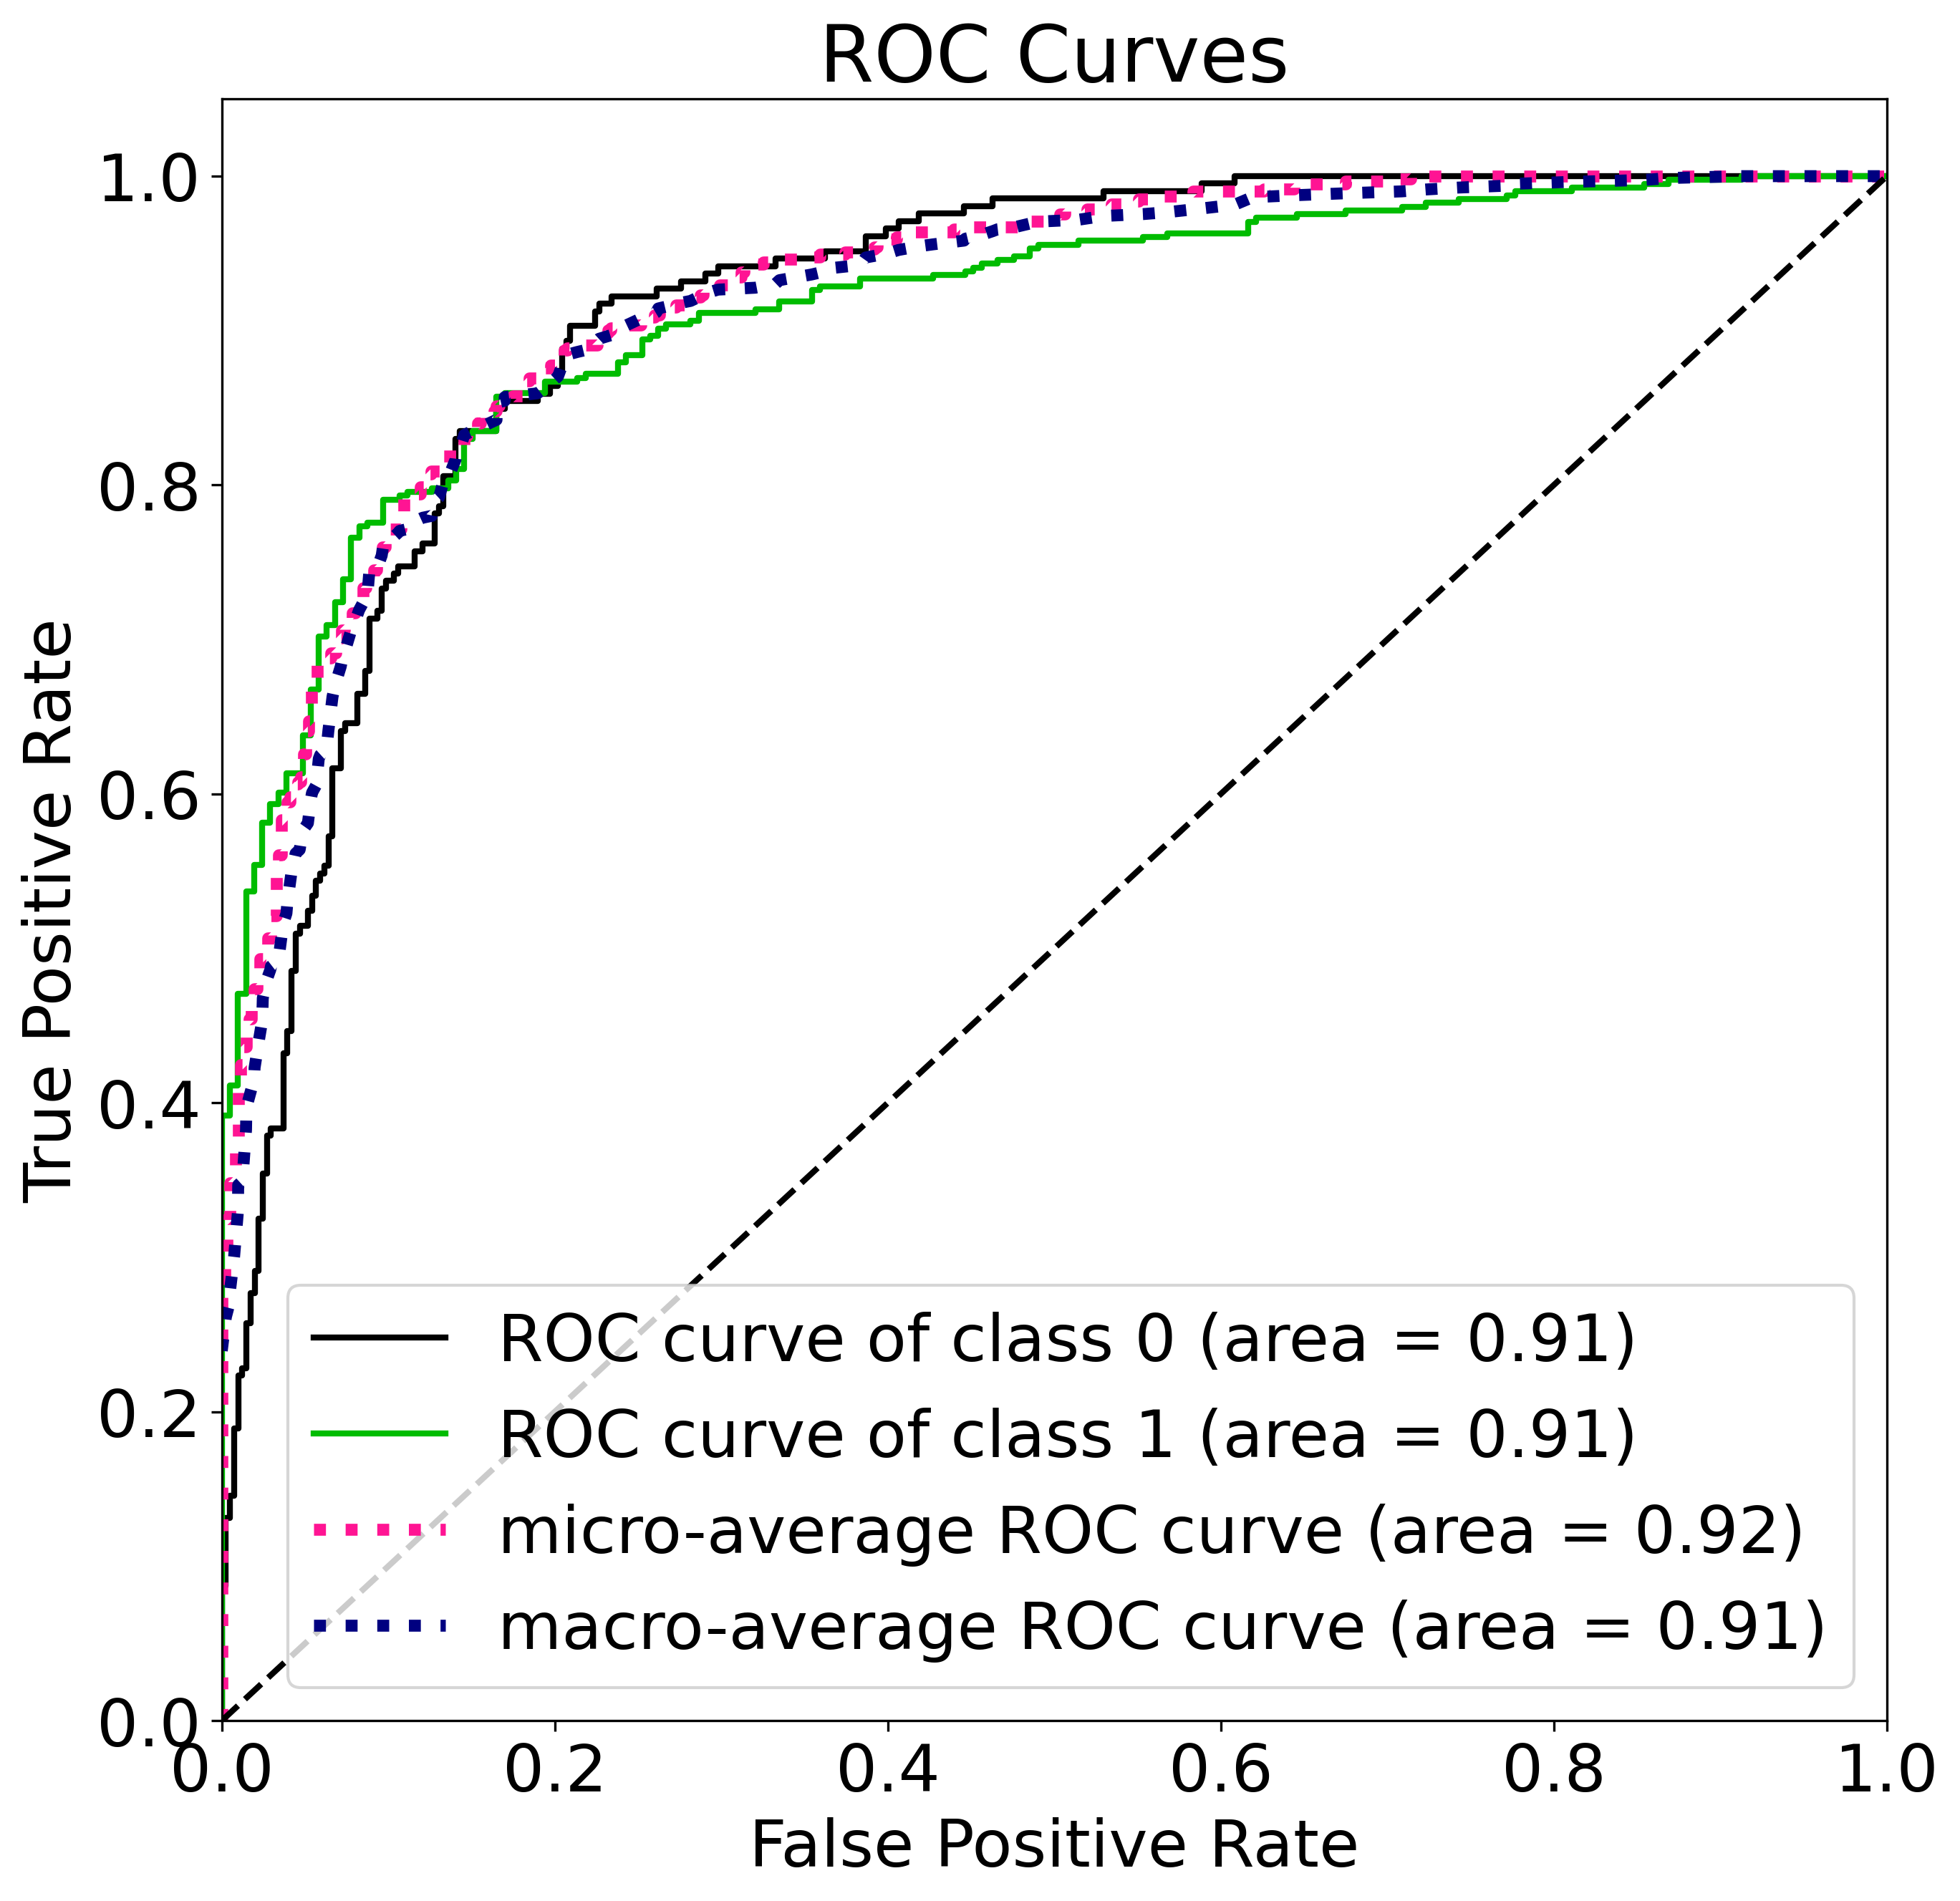

In [18]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

rcParams['font.size'] = 22

y_true = y_test
y_probas = ensemble_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show

#### Conduct permutation importance, Shapley-based importance, and create partial dependency plots using the highly influential features.

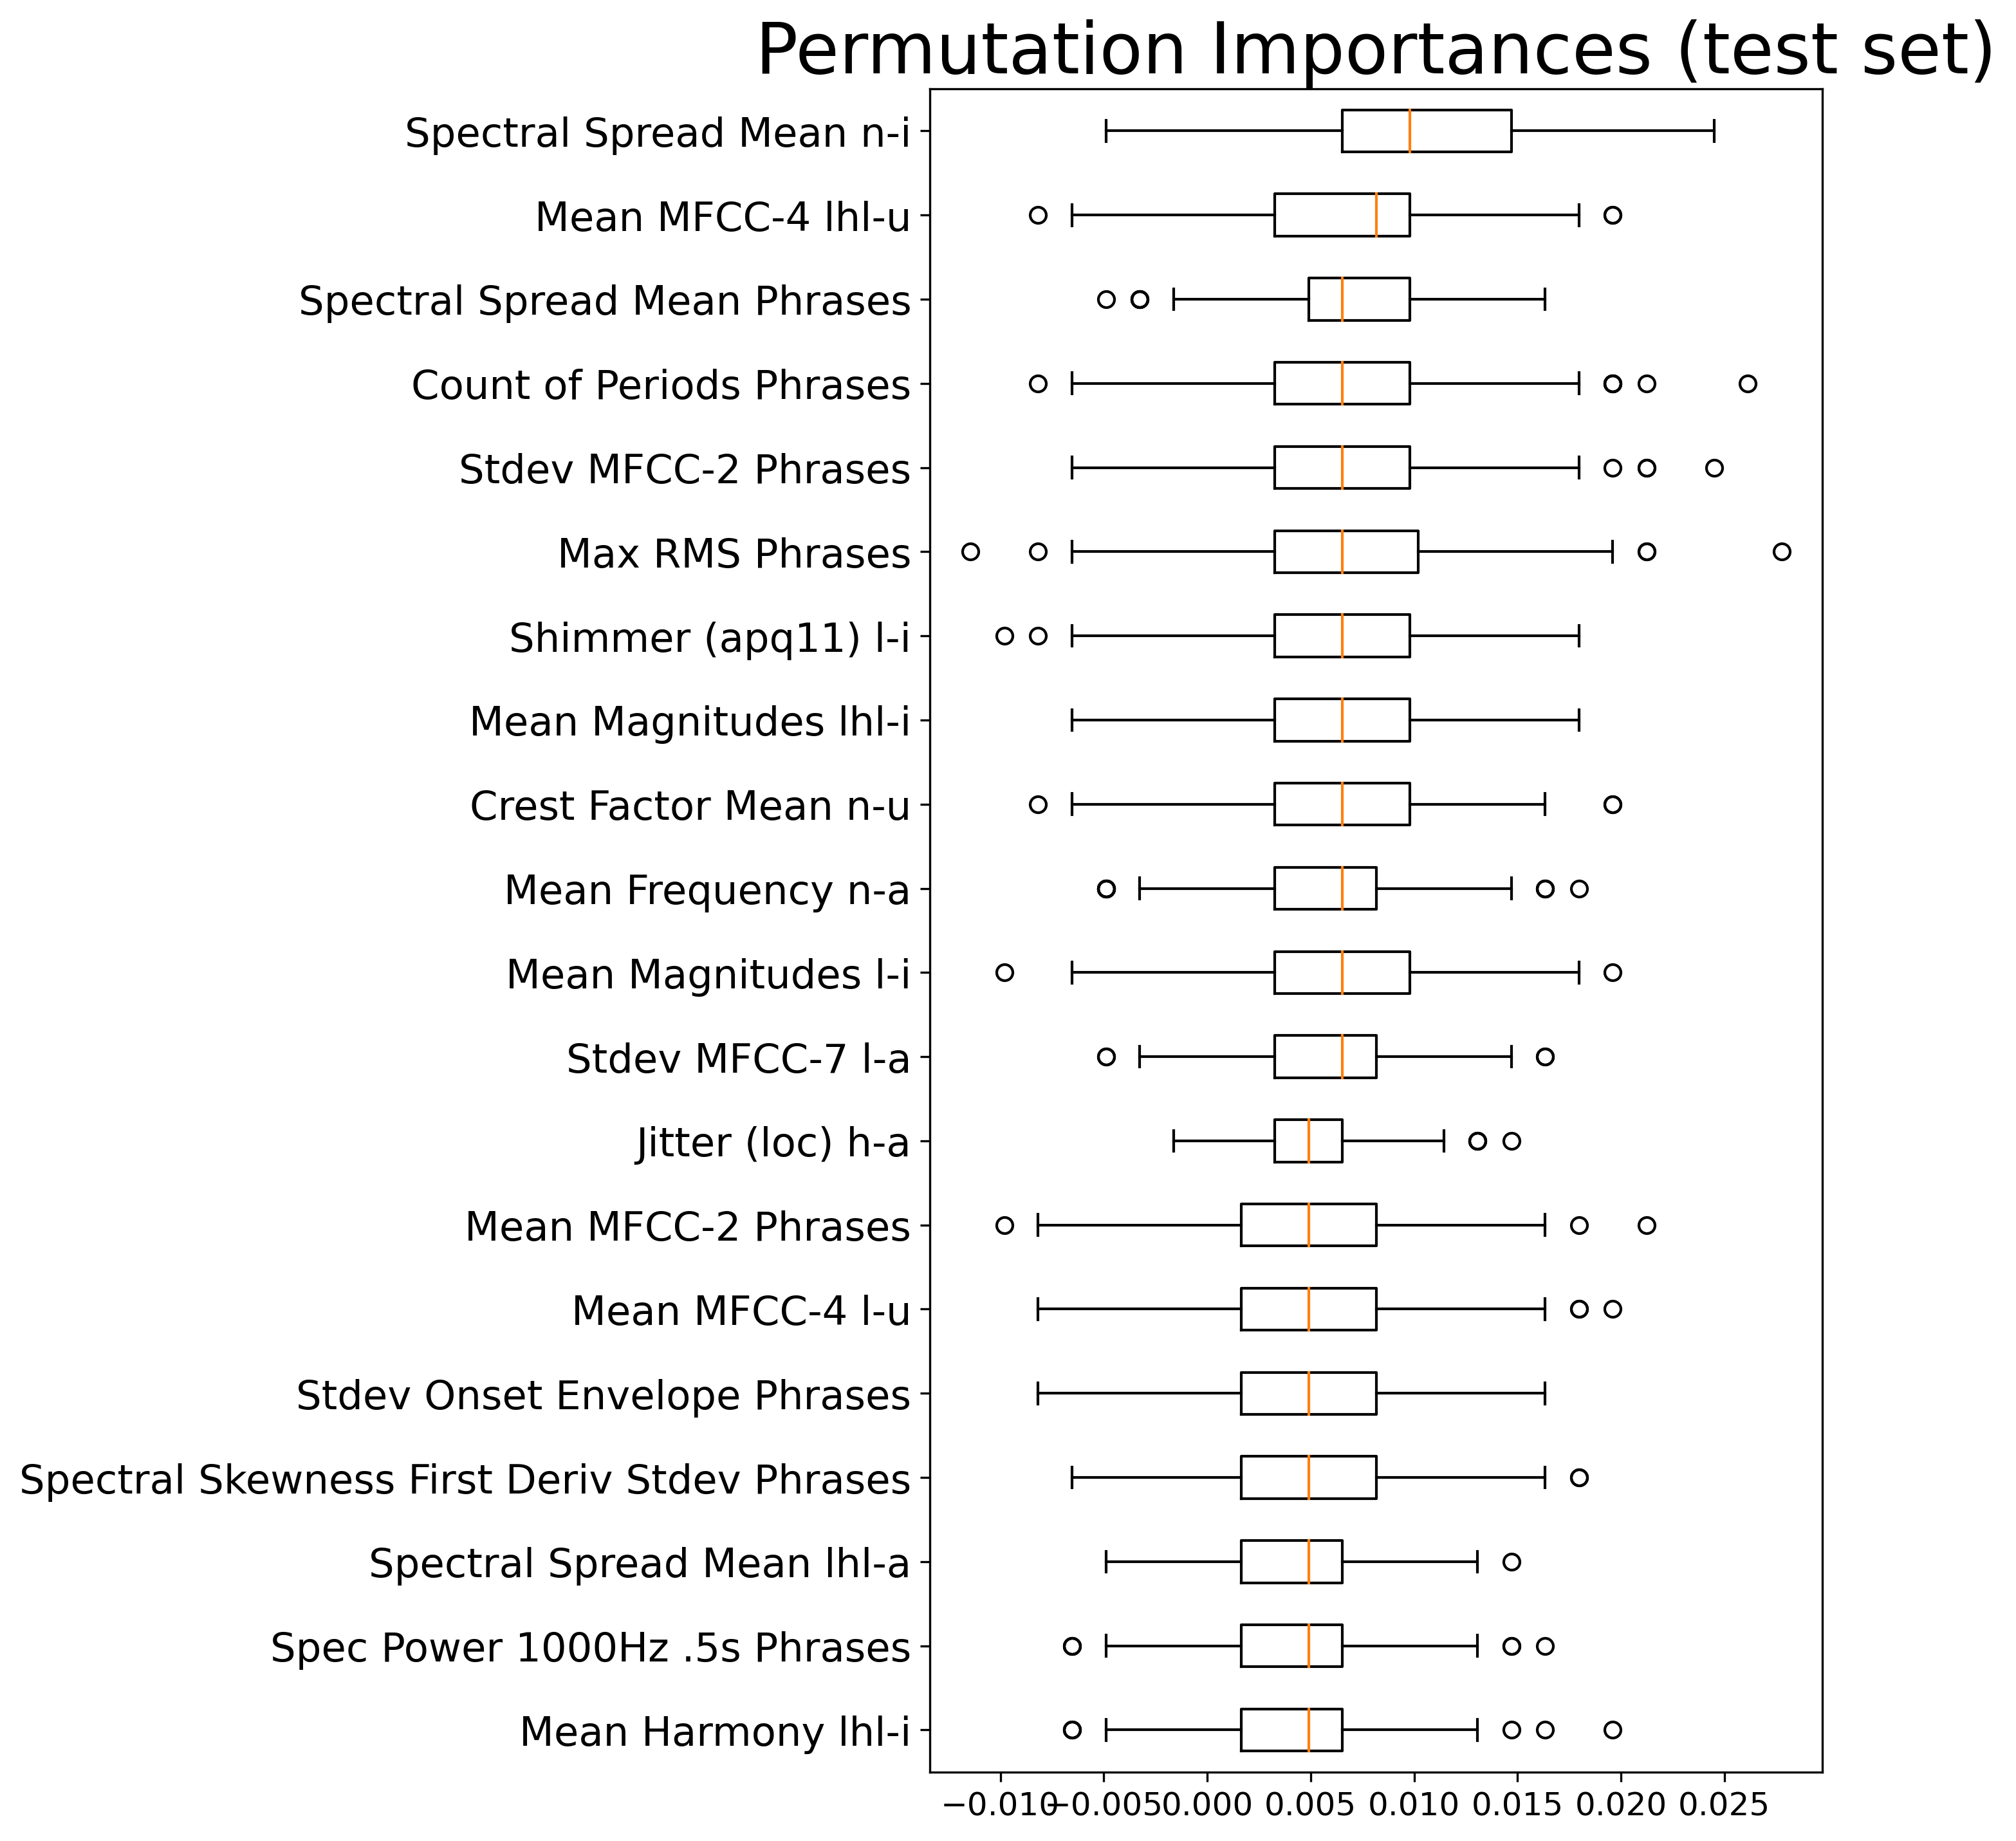

In [19]:
import matplotlib
from sklearn.inspection import permutation_importance

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

result = permutation_importance(ensemble_clf, X_test, y_test, n_repeats = 500,
                                random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Permutation explainer: 613it [18:33,  1.83s/it]                                                                        


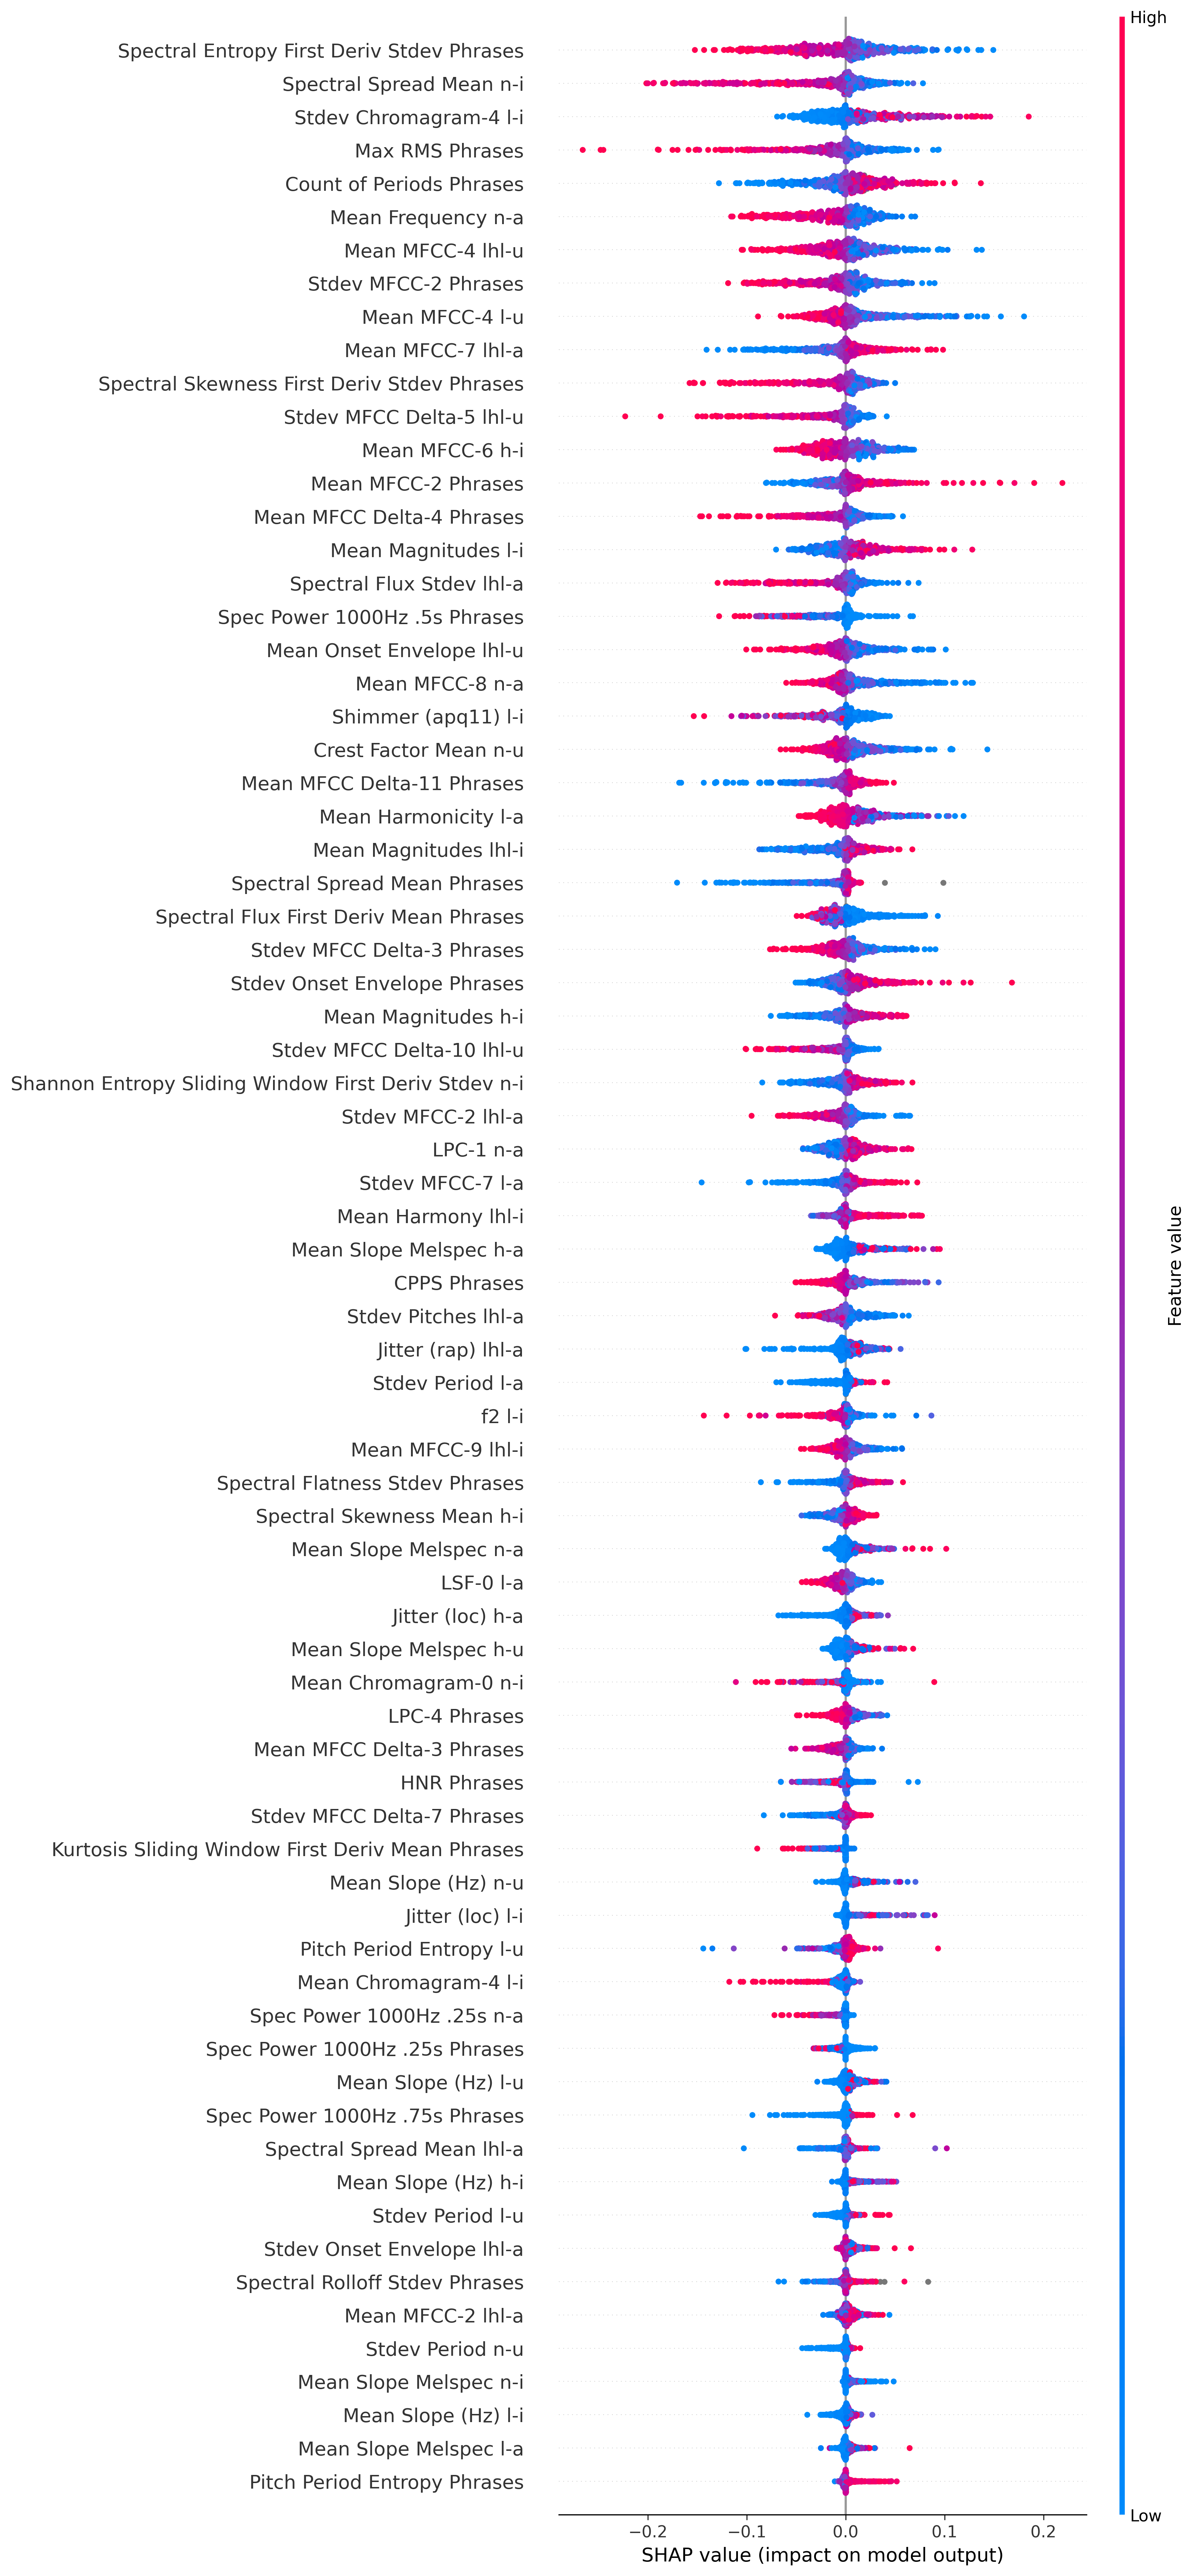

In [20]:
import shap

f = lambda x: ensemble_clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[:,:])

shap.plots.beeswarm(shap_values)

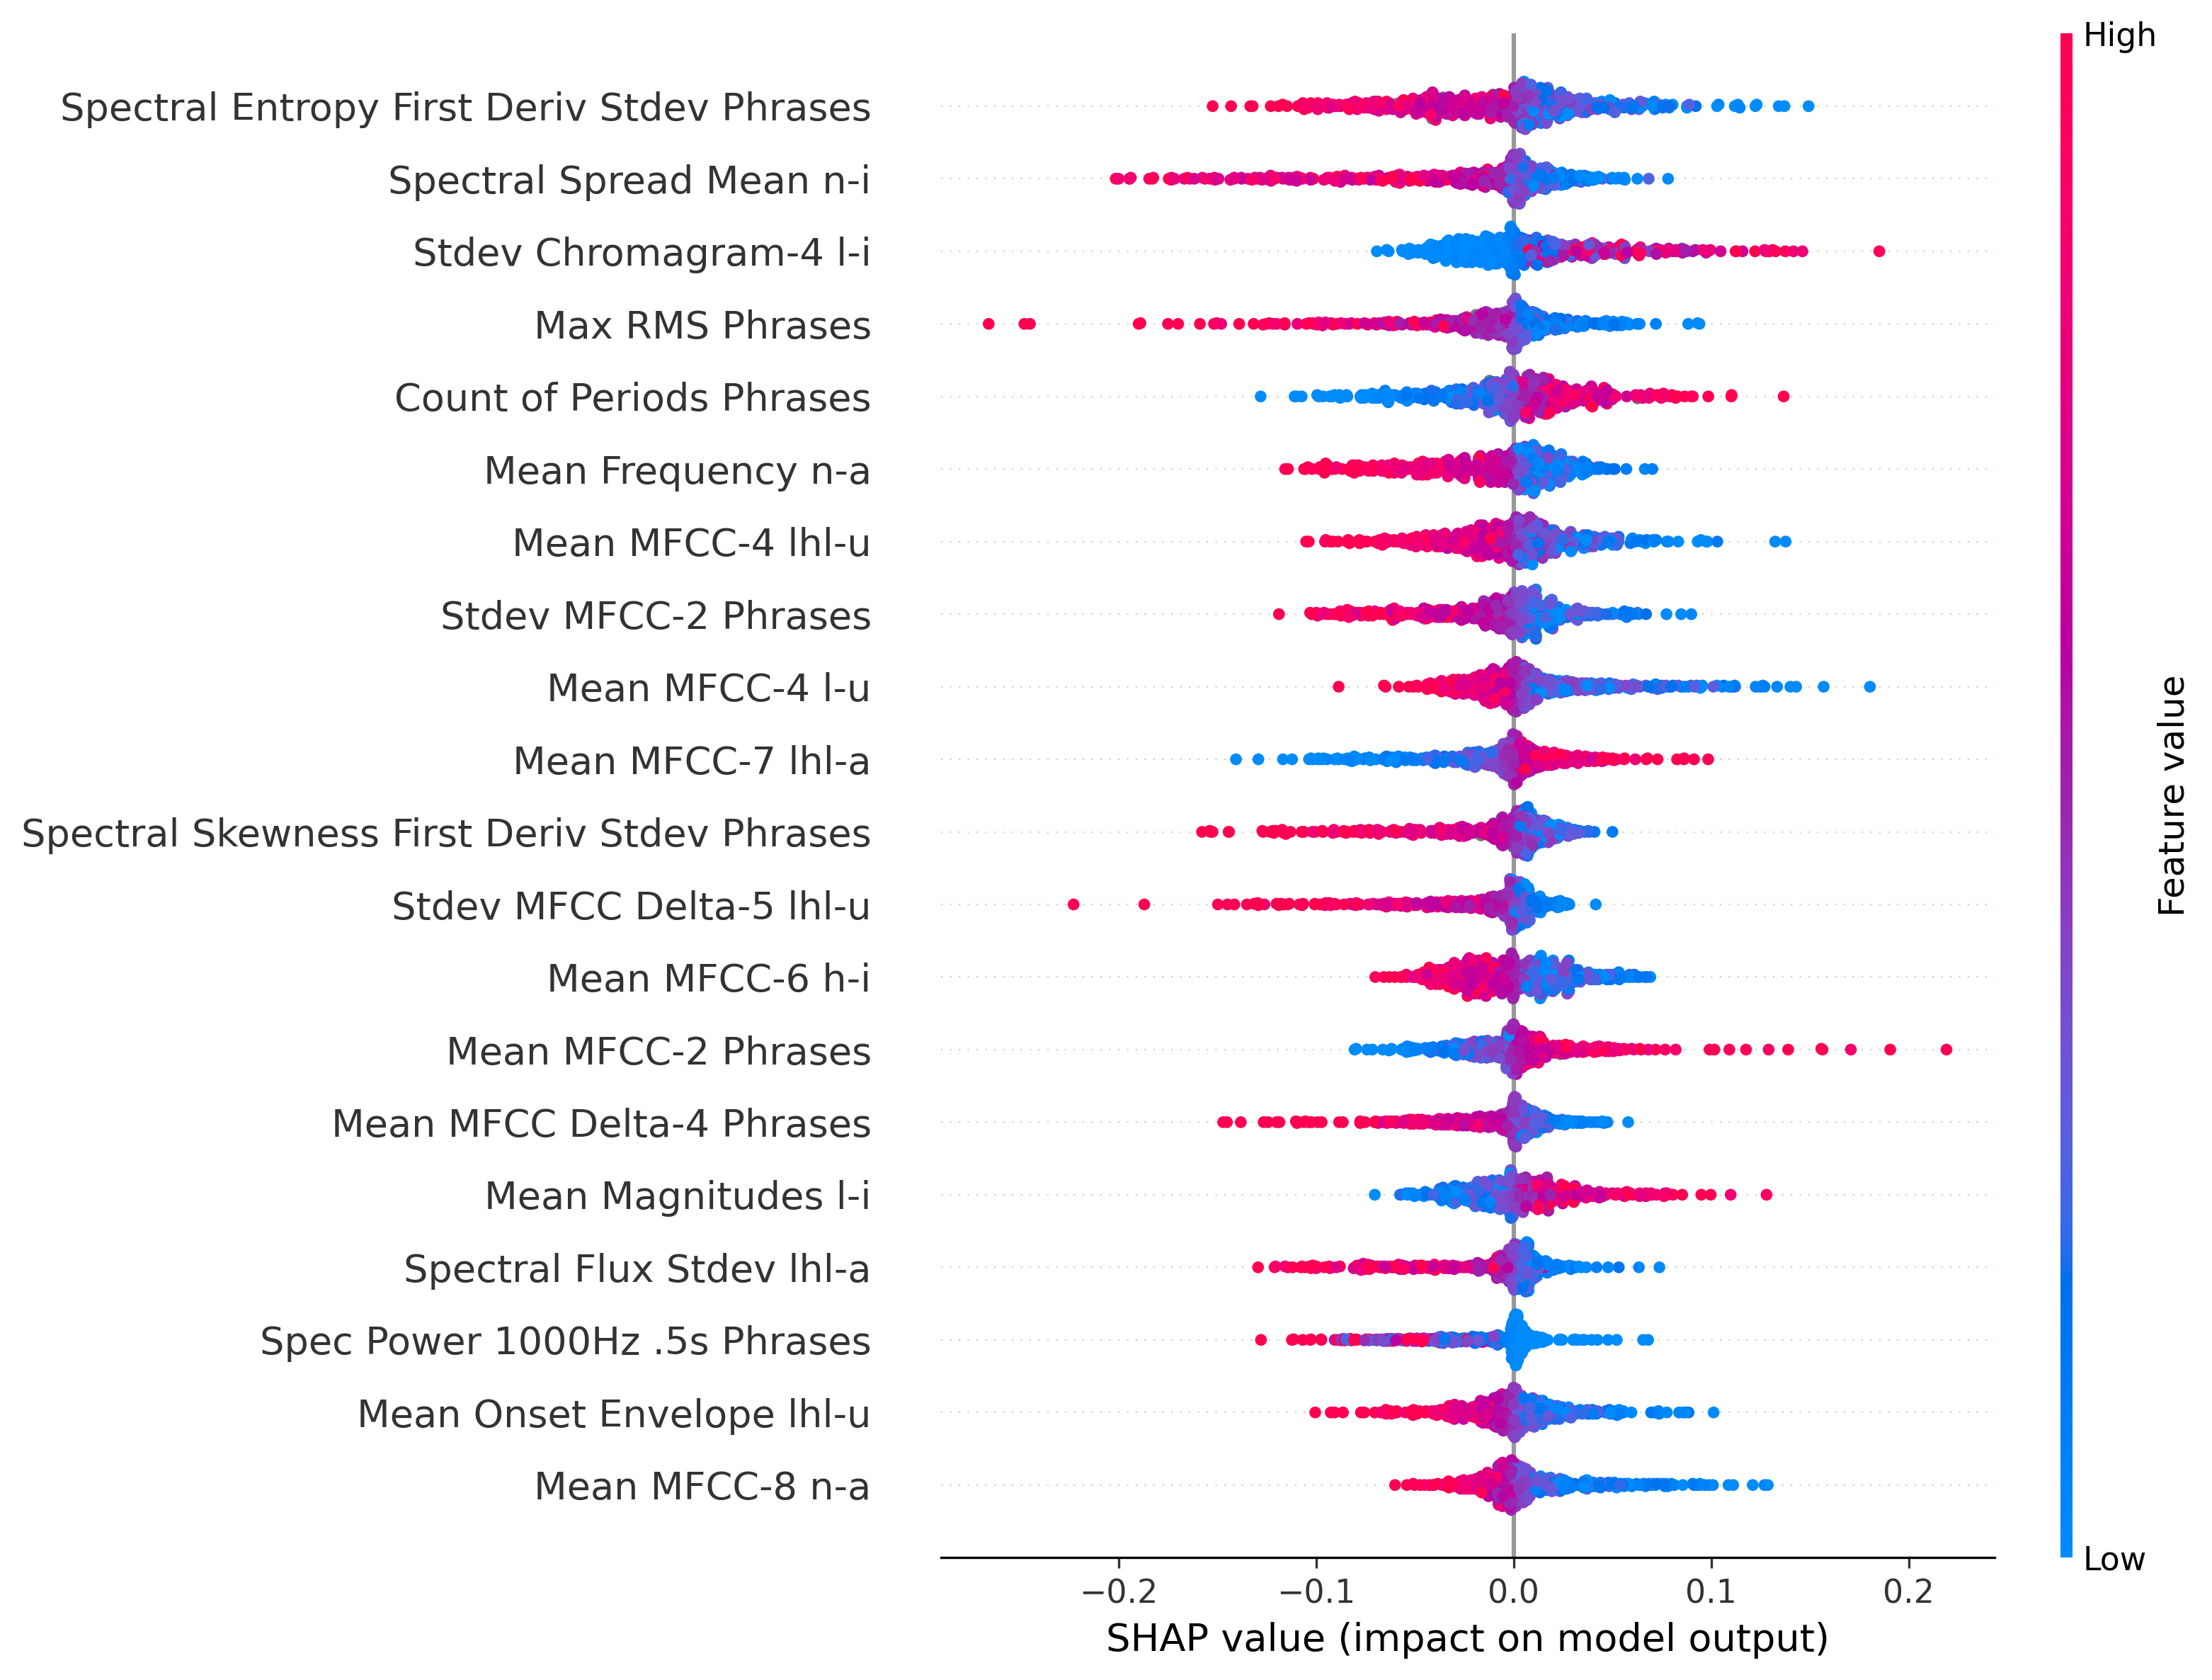

In [21]:
top = ['Spectral Entropy First Deriv Stdev Phrases', 'Spectral Spread Mean n-i', 'Stdev Chromagram-4 l-i',
      'Max RMS Phrases', 'Count of Periods Phrases', 'Mean Frequency n-a', 'Mean MFCC-4 lhl-u', 'Stdev MFCC-2 Phrases',
      'Mean MFCC-4 l-u', 'Mean MFCC-7 lhl-a', 'Spectral Skewness First Deriv Stdev Phrases', 'Stdev MFCC Delta-5 lhl-u',
      'Mean MFCC-6 h-i', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-4 Phrases', 'Mean Magnitudes l-i', 'Spectral Flux Stdev lhl-a',
      'Spec Power 1000Hz .5s Phrases', 'Mean Onset Envelope lhl-u', 'Mean MFCC-8 n-a']

top_loc=[X.columns.get_loc(c) for c in top if c in X]
shap.plots.beeswarm(shap_values[:,top_loc])

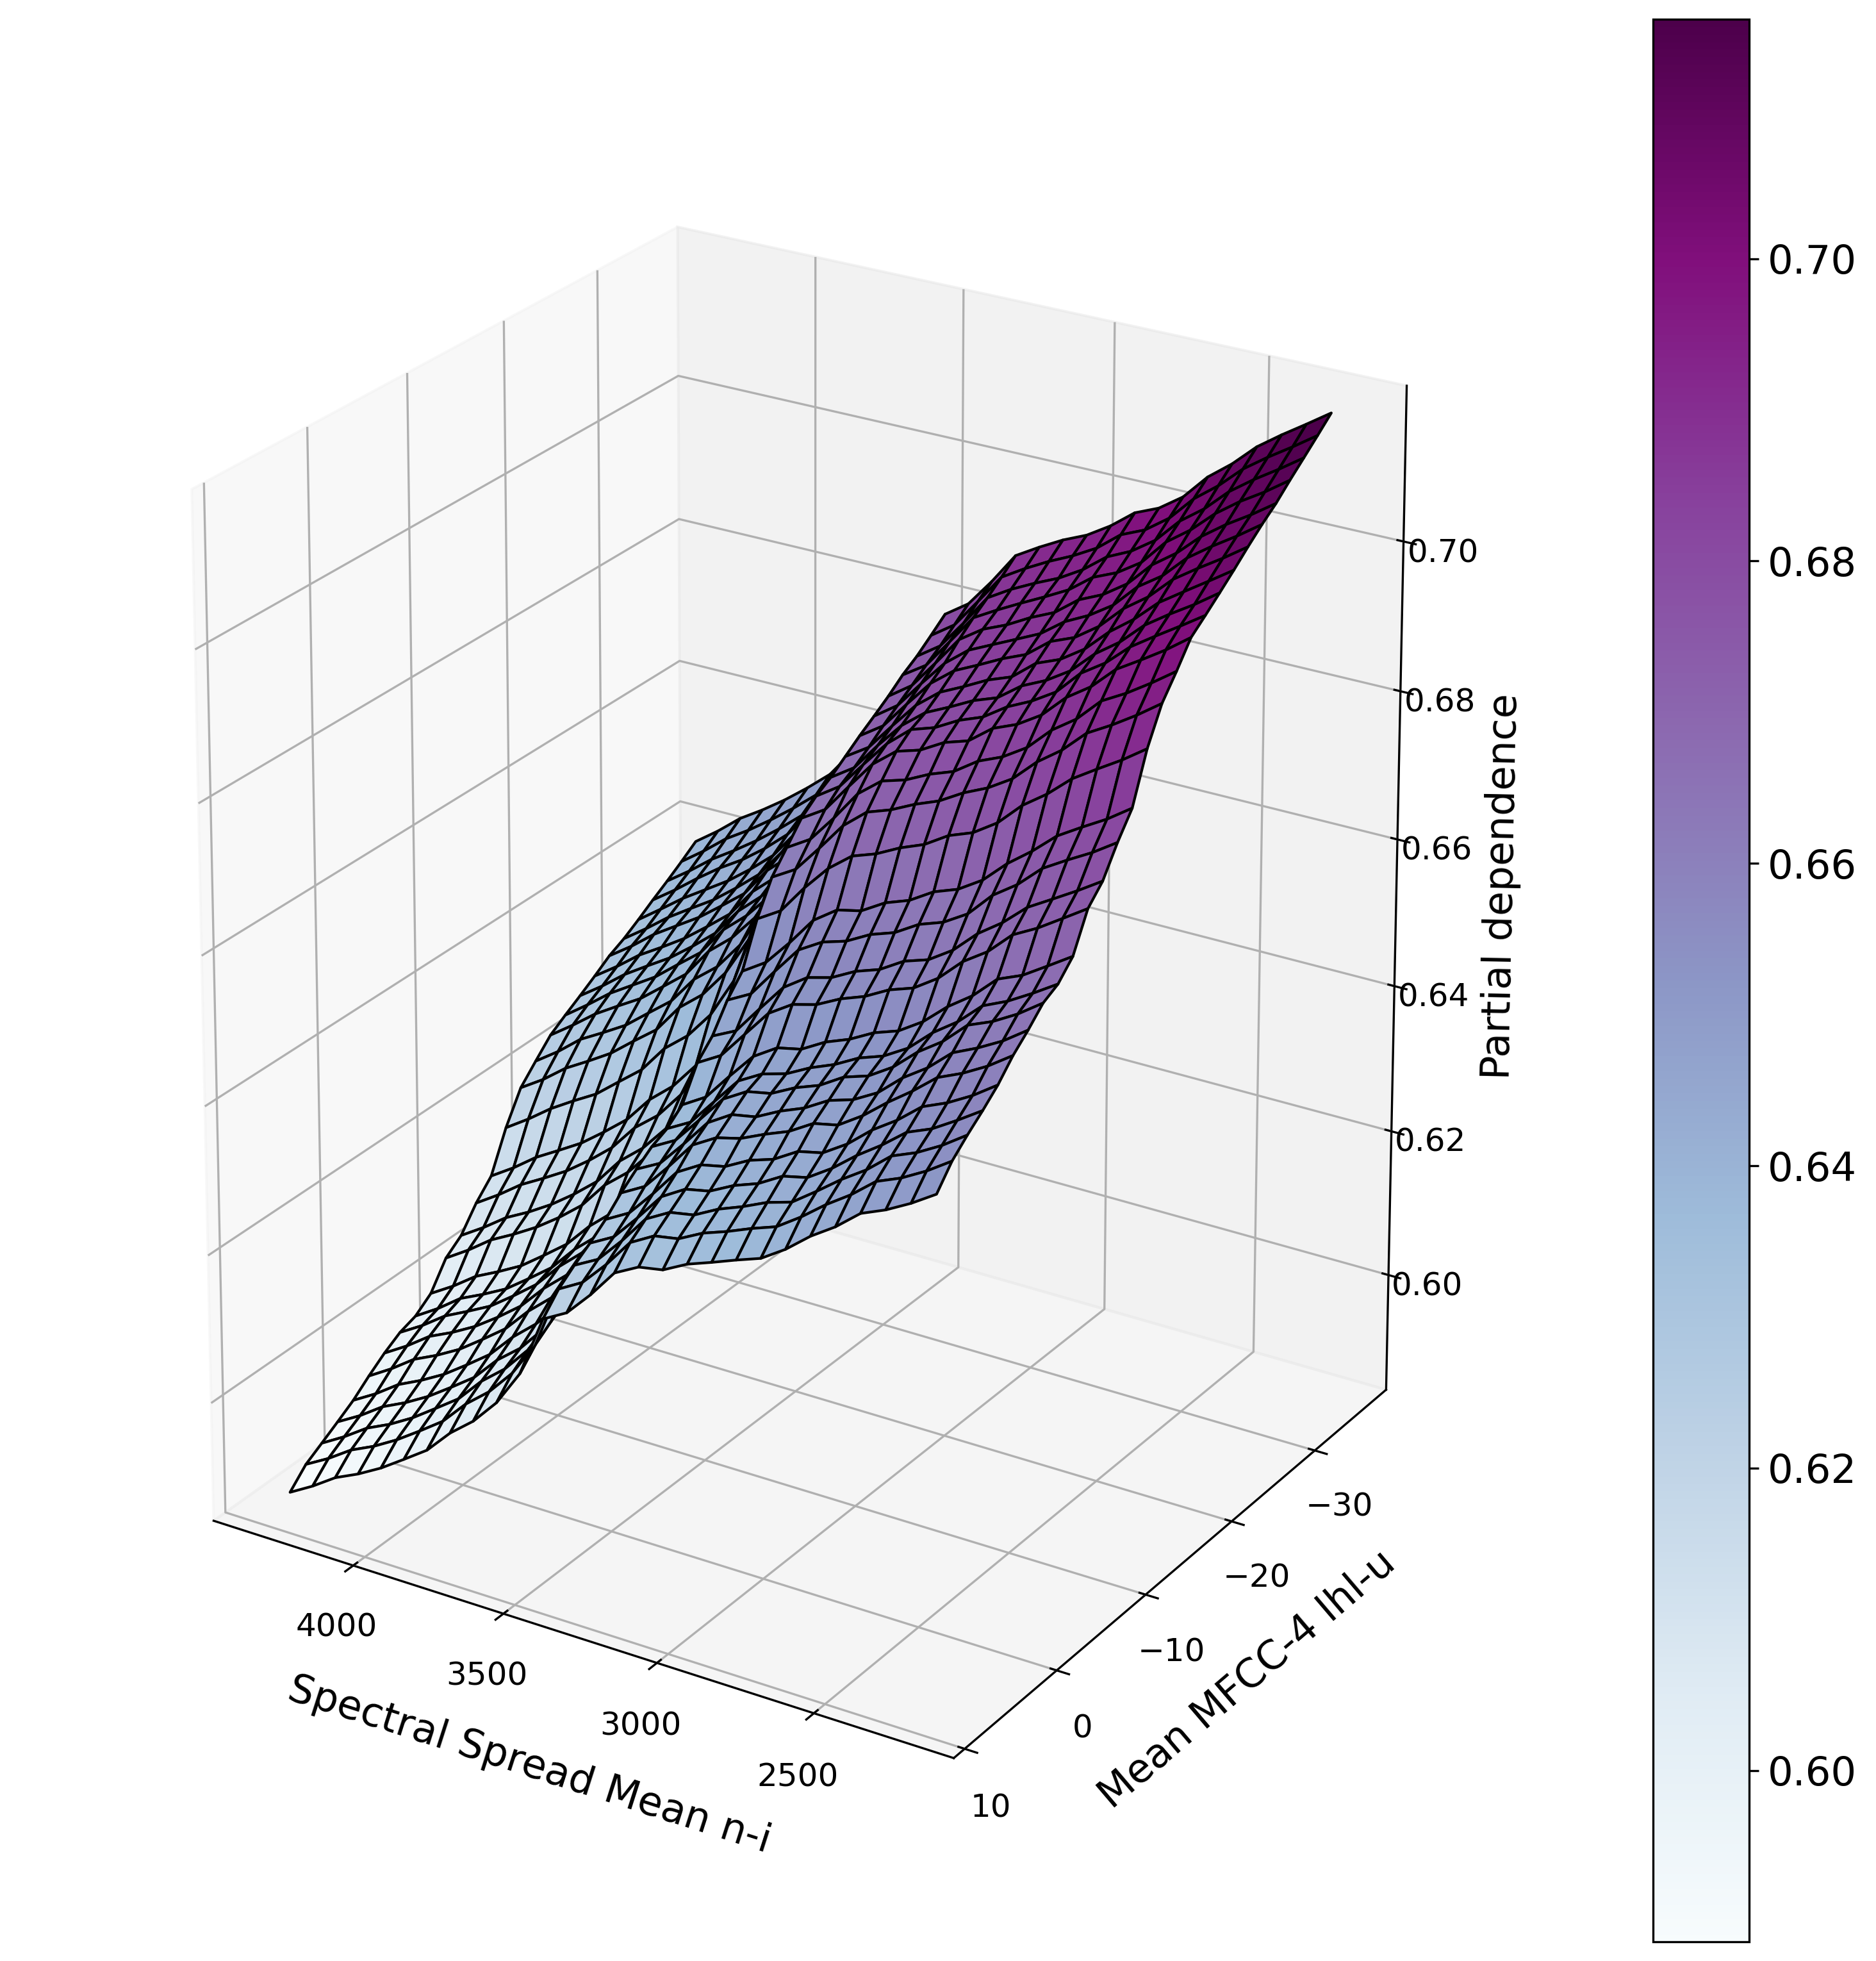

In [22]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spectral Spread Mean n-i', 'Mean MFCC-4 lhl-u')
pdp = partial_dependence(
    ensemble_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=20, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

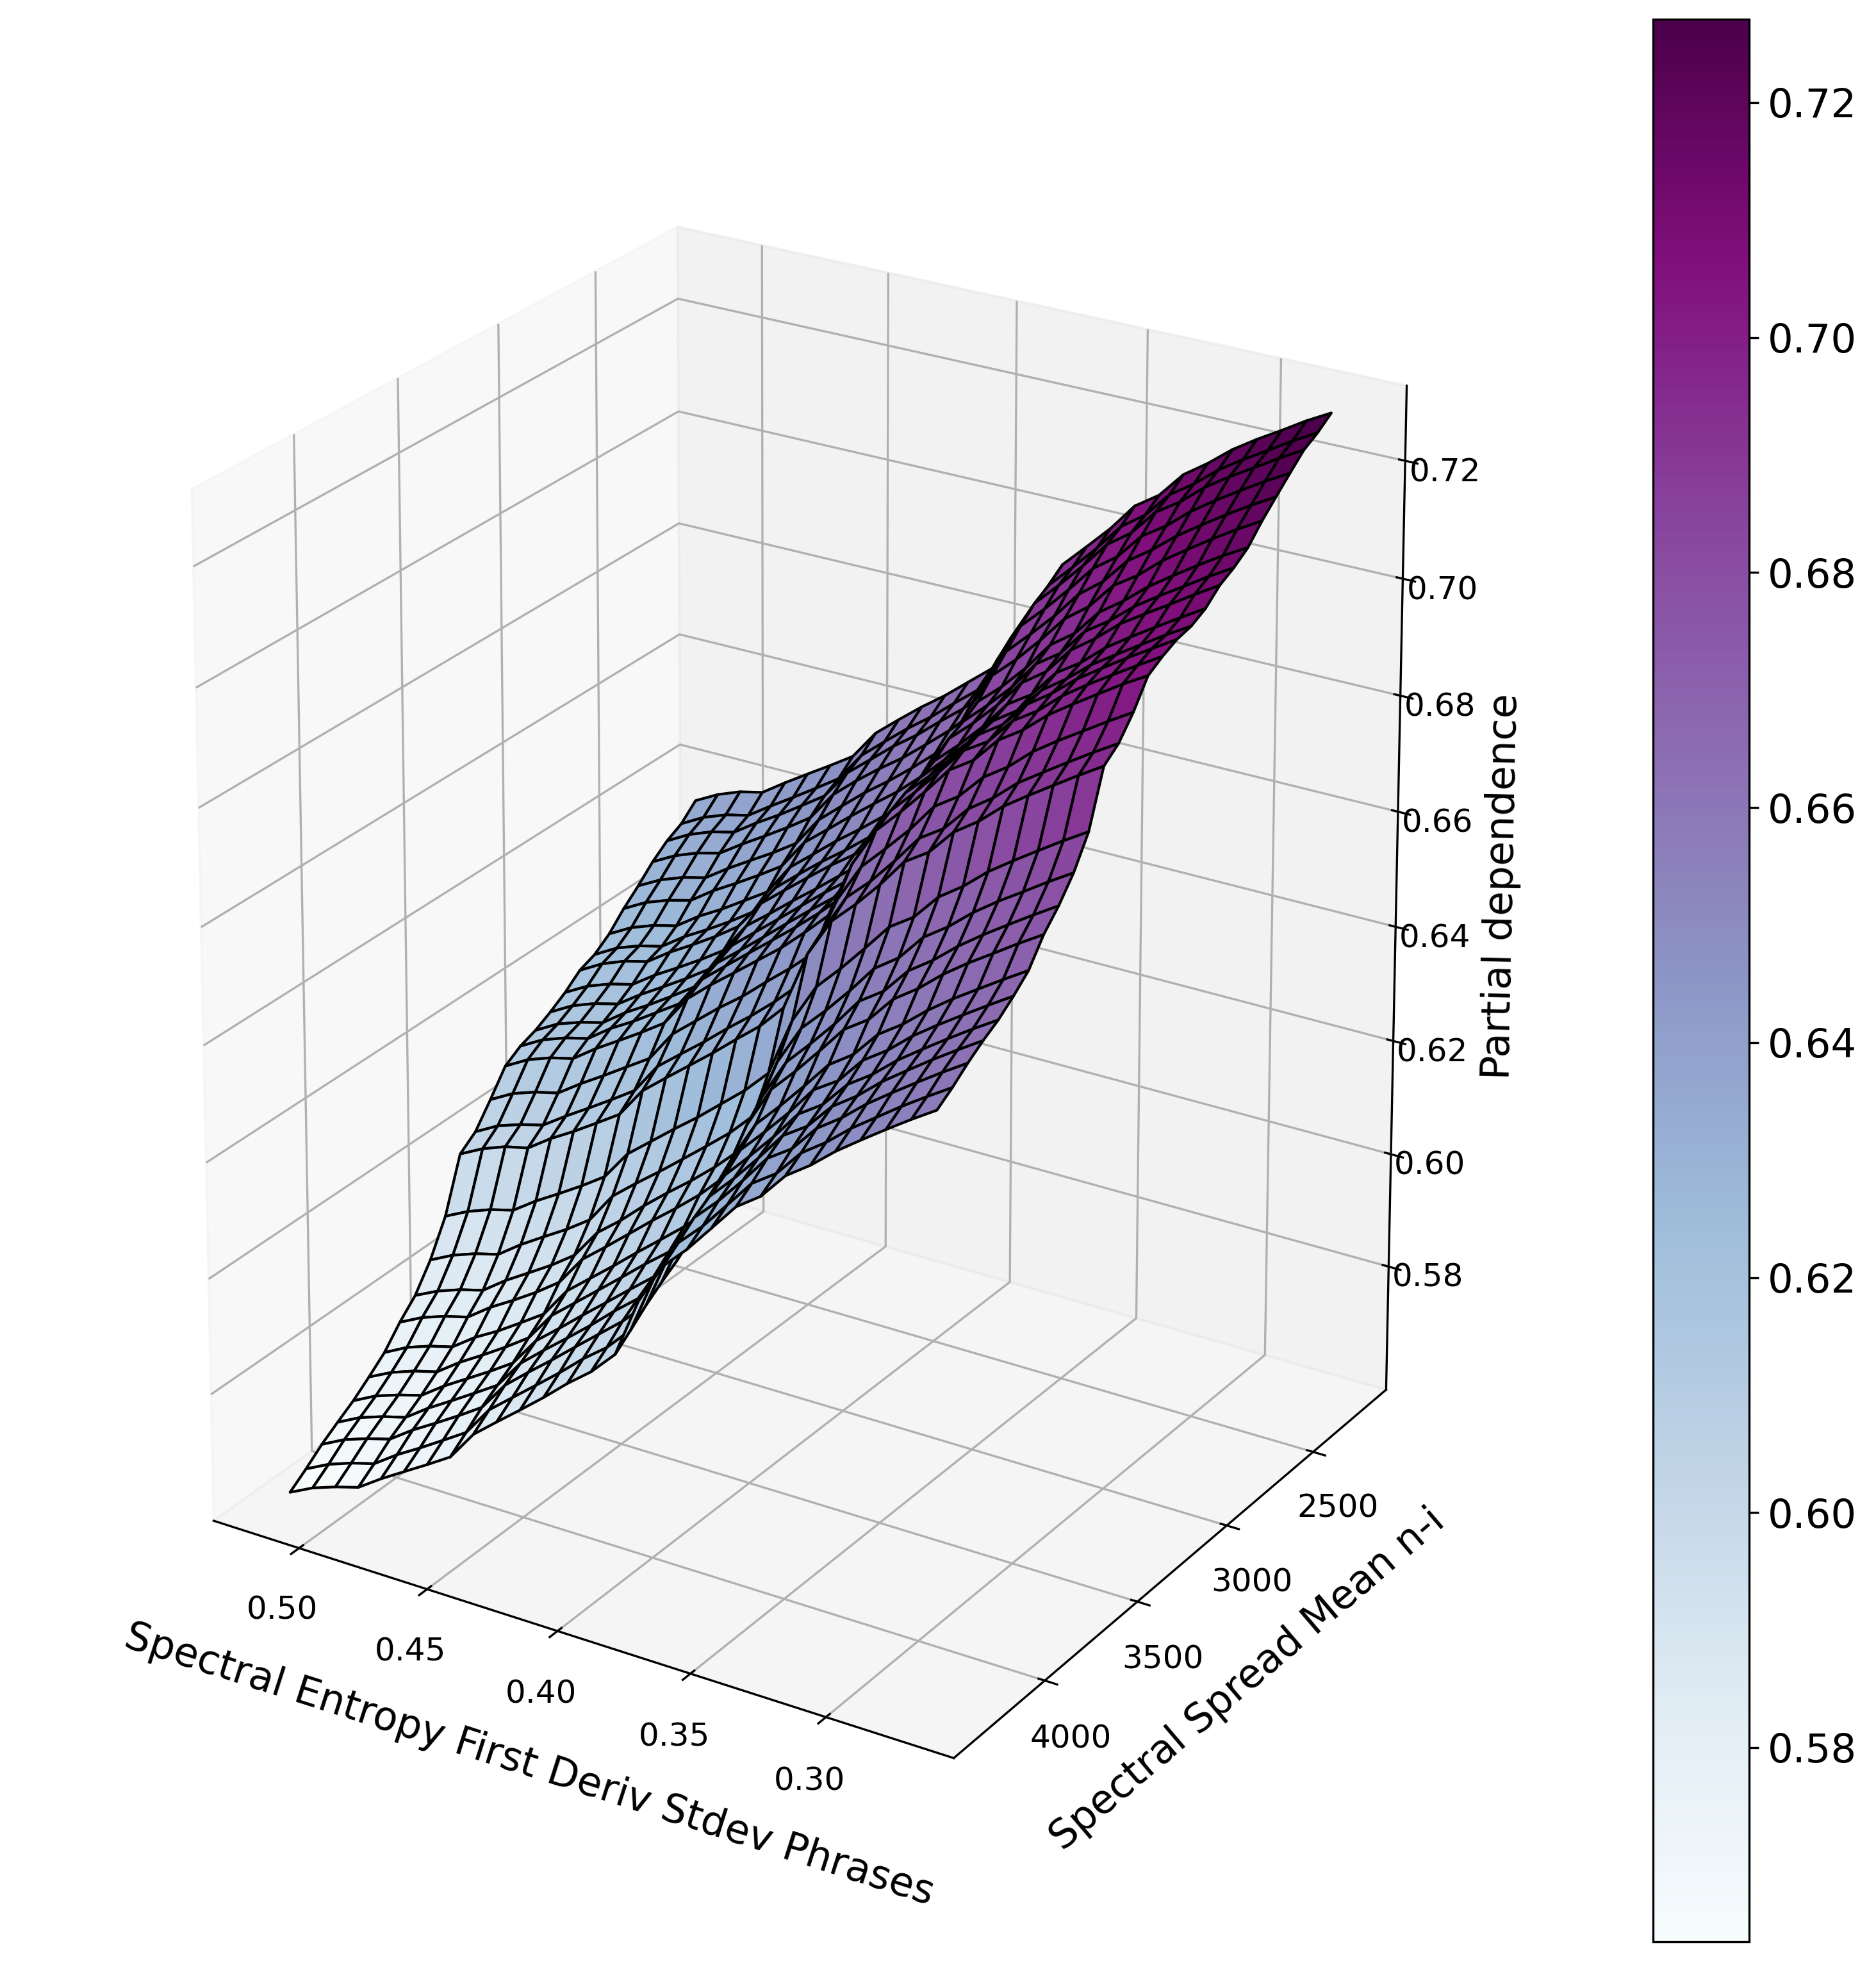

In [23]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spectral Entropy First Deriv Stdev Phrases', 'Spectral Spread Mean n-i')
pdp = partial_dependence(
    ensemble_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)
ax.view_init(elev=20, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

#### Evaluate performance of the classifier across demographics variables. Note: Only subsets that included at least 20 instances were kept for this analysis.

In [24]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['recording_num','y'], axis = 1)

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
X = X.drop('high_indexphrase_features', axis = 1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

X = pd.concat([X, sex, age], axis = 1)

Total number of features dropped was... 30 
Remaining features...  74


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

mask_s0 = (X_test['sex'] == 0)
mask_s1 = (X_test['sex'] == 1)

mask_s0_age_1 = ((X_test['sex'] == 0) & (X_test['age'] == 1)) 
mask_s0_age_2 = ((X_test['sex'] == 0) & (X_test['age'] == 2))
mask_s0_age_3 = ((X_test['sex'] == 0) & (X_test['age'] == 3))
mask_s0_age_4 = ((X_test['sex'] == 0) & (X_test['age'] == 4))
mask_s0_age_5 = ((X_test['sex'] == 0) & (X_test['age'] == 5))
mask_s0_age_6 = ((X_test['sex'] == 0) & (X_test['age'] == 6))
mask_s0_age_7 = ((X_test['sex'] == 0) & (X_test['age'] == 7))

mask_s1_age_2 = ((X_test['sex'] == 1) & (X_test['age'] == 2))
mask_s1_age_3 = ((X_test['sex'] == 1) & (X_test['age'] == 3))
mask_s1_age_4 = ((X_test['sex'] == 1) & (X_test['age'] == 4))
mask_s1_age_5 = ((X_test['sex'] == 1) & (X_test['age'] == 5))
mask_s1_age_6 = ((X_test['sex'] == 1) & (X_test['age'] == 6))
mask_s1_age_7 = ((X_test['sex'] == 1) & (X_test['age'] == 7))

X_train = X_train.drop(['sex','age'], axis = 1)
X_test = X_test.drop(['sex','age'], axis = 1)

In [26]:
print('sex: F, age: 10-19\n', classification_report(y_test[mask_s0_age_1], ensemble_clf.predict(X_test[mask_s0_age_1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_1], ensemble_clf.predict(X_test[mask_s0_age_1]), average=None))

sex: F, age: 10-19
               precision    recall  f1-score   support

      benign     0.9565    0.8462    0.8980        26
   anomalous     0.3333    0.6667    0.4444         3

    accuracy                         0.8276        29
   macro avg     0.6449    0.7564    0.6712        29
weighted avg     0.8921    0.8276    0.8510        29

0.7564102564102564


In [27]:
print('sex: F, age: 20-29\n', classification_report(y_test[mask_s0_age_2], ensemble_clf.predict(X_test[mask_s0_age_2]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_2], ensemble_clf.predict(X_test[mask_s0_age_2]), average=None))

sex: F, age: 20-29
               precision    recall  f1-score   support

      benign     0.8191    0.8652    0.8415        89
   anomalous     0.5862    0.5000    0.5397        34

    accuracy                         0.7642       123
   macro avg     0.7027    0.6826    0.6906       123
weighted avg     0.7548    0.7642    0.7581       123



0.6825842696629213

In [28]:
print('sex: F, age: 30-39\n', classification_report(y_test[mask_s0_age_3], ensemble_clf.predict(X_test[mask_s0_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_3], ensemble_clf.predict(X_test[mask_s0_age_3]), average=None))

sex: F, age: 30-39
               precision    recall  f1-score   support

      benign     0.5000    0.6667    0.5714         6
   anomalous     0.9429    0.8919    0.9167        37

    accuracy                         0.8605        43
   macro avg     0.7214    0.7793    0.7440        43
weighted avg     0.8811    0.8605    0.8685        43

0.7792792792792793


In [29]:
print('sex: F, age: 40-49\n', classification_report(y_test[mask_s0_age_4], ensemble_clf.predict(X_test[mask_s0_age_4]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_4], ensemble_clf.predict(X_test[mask_s0_age_4]), average=None))

sex: F, age: 40-49
               precision    recall  f1-score   support

      benign     0.1429    0.2500    0.1818         4
   anomalous     0.9143    0.8421    0.8767        38

    accuracy                         0.7857        42
   macro avg     0.5286    0.5461    0.5293        42
weighted avg     0.8408    0.7857    0.8105        42



0.5460526315789473

In [30]:
print('sex: F, age: 50-59\n', classification_report(y_test[mask_s0_age_5], ensemble_clf.predict(X_test[mask_s0_age_5]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_5], ensemble_clf.predict(X_test[mask_s0_age_5]), average=None))

sex: F, age: 50-59
               precision    recall  f1-score   support

      benign     0.5000    0.2500    0.3333         4
   anomalous     0.9400    0.9792    0.9592        48

    accuracy                         0.9231        52
   macro avg     0.7200    0.6146    0.6463        52
weighted avg     0.9062    0.9231    0.9110        52



0.6145833333333333

In [31]:
print('sex: F, age: 60-69\n', classification_report(y_test[mask_s0_age_6], ensemble_clf.predict(X_test[mask_s0_age_6]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_6], ensemble_clf.predict(X_test[mask_s0_age_6]), average=None))

sex: F, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         1
   anomalous     0.9750    0.9750    0.9750        40

    accuracy                         0.9512        41
   macro avg     0.4875    0.4875    0.4875        41
weighted avg     0.9512    0.9512    0.9512        41



0.4875

In [32]:
print('sex: F, age: 70-79\n', classification_report(y_test[mask_s0_age_7], ensemble_clf.predict(X_test[mask_s0_age_7]), digits = 4))

sex: F, age: 70-79
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        23

    accuracy                         1.0000        23
   macro avg     1.0000    1.0000    1.0000        23
weighted avg     1.0000    1.0000    1.0000        23



In [33]:
print('sex: M, age: 20-29\n', classification_report(y_test[mask_s1_age_2], ensemble_clf.predict(X_test[mask_s1_age_2]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_2], ensemble_clf.predict(X_test[mask_s1_age_2]), average=None))

sex: M, age: 20-29
               precision    recall  f1-score   support

      benign     0.8710    0.6000    0.7105        45
   anomalous     0.1818    0.5000    0.2667         8

    accuracy                         0.5849        53
   macro avg     0.5264    0.5500    0.4886        53
weighted avg     0.7669    0.5849    0.6435        53



0.5499999999999999

In [34]:
print('sex: M, age: 30-39\n', classification_report(y_test[mask_s1_age_3], ensemble_clf.predict(X_test[mask_s1_age_3]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_3], ensemble_clf.predict(X_test[mask_s1_age_3]), average=None))

sex: M, age: 30-39
               precision    recall  f1-score   support

      benign     0.7333    0.7857    0.7586        14
   anomalous     0.8125    0.7647    0.7879        17

    accuracy                         0.7742        31
   macro avg     0.7729    0.7752    0.7732        31
weighted avg     0.7767    0.7742    0.7747        31



0.7752100840336134

In [35]:
print('sex: M, age: 40-49\n', classification_report(y_test[mask_s1_age_4], ensemble_clf.predict(X_test[mask_s1_age_4]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_4], ensemble_clf.predict(X_test[mask_s1_age_4]), average=None))

sex: M, age: 40-49
               precision    recall  f1-score   support

      benign     0.7500    1.0000    0.8571         6
   anomalous     1.0000    0.9200    0.9583        25

    accuracy                         0.9355        31
   macro avg     0.8750    0.9600    0.9077        31
weighted avg     0.9516    0.9355    0.9387        31



0.96

In [36]:
print('sex: M, age: 50-59\n', classification_report(y_test[mask_s1_age_5], ensemble_clf.predict(X_test[mask_s1_age_5]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_5], ensemble_clf.predict(X_test[mask_s1_age_5]), average=None))

sex: M, age: 50-59
               precision    recall  f1-score   support

      benign     0.6667    0.4000    0.5000         5
   anomalous     0.9423    0.9800    0.9608        50

    accuracy                         0.9273        55
   macro avg     0.8045    0.6900    0.7304        55
weighted avg     0.9172    0.9273    0.9189        55



0.69

In [37]:
print('sex: M, age: 60-69\n', classification_report(y_test[mask_s1_age_6], ensemble_clf.predict(X_test[mask_s1_age_6]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_6], ensemble_clf.predict(X_test[mask_s1_age_6]), average=None))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


sex: M, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         2
   anomalous     0.9615    1.0000    0.9804        50

    accuracy                         0.9615        52
   macro avg     0.4808    0.5000    0.4902        52
weighted avg     0.9246    0.9615    0.9427        52



0.5

In [38]:
print('sex: M, age: 70-79, note: only 1 class has support\n', classification_report(y_test[mask_s1_age_7], ensemble_clf.predict(X_test[mask_s1_age_7]), digits = 4))

sex: M, age: 70-79, note: only 1 class has support
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



In [39]:
print('sex: F\n', classification_report(y_test[mask_s0], ensemble_clf.predict(X_test[mask_s0]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0], ensemble_clf.predict(X_test[mask_s0]), average=None))

sex: F
               precision    recall  f1-score   support

      benign     0.7778    0.8015    0.7895       131
   anomalous     0.8818    0.8661    0.8739       224

    accuracy                         0.8423       355
   macro avg     0.8298    0.8338    0.8317       355
weighted avg     0.8434    0.8423    0.8427       355



0.8337990730643403

In [40]:
print('sex: M\n', classification_report(y_test[mask_s1], ensemble_clf.predict(X_test[mask_s1]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1], ensemble_clf.predict(X_test[mask_s1]), average=None))

sex: M
               precision    recall  f1-score   support

      benign     0.7903    0.6533    0.7153        75
   anomalous     0.8667    0.9286    0.8966       182

    accuracy                         0.8482       257
   macro avg     0.8285    0.7910    0.8059       257
weighted avg     0.8444    0.8482    0.8437       257



0.790952380952381

#### Pickle the model for later use.

In [41]:
pkl_filename = "Stacking_Classifier_1_26_.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(ensemble_clf, file)